# Overview

This is a toy project for exploring mechanistic interpretability methods. We train a small neural network to detect the presence of an ascii face in a string, then draw some conclusions about the network internals.

## Dataset

Our challenge to the toy model will be to classify a text string as either containing an ASCII face or not.

Dataset generation and unicode escape sequence cleaning and padding out the data courtesy of GPT-5 (see https://chatgpt.com/c/690e24c8-a990-832d-9711-8f0cb77e94a3).

Define dictionary of cute faces for our dataset. We'll interleave these among random characters from the same charset to present a challenge to the model.

In [1]:
import random
import string

# Dictionary of horizontally-oriented ASCII faces (≈100 entries)
ascii_faces = {
    "happy": "(^_^)",
    "big_smile": "(^o^)",
    "winky": "(^_~)",
    "surprised": "(O_O)",
    "disappointed": "(>_<)",
    "cool": "(⌐■_■)",
    "thinking": "(¬_¬)",
    "angry": "(ಠ_ಠ)",
    "lenny": "( ͡° ͜ʖ ͡°)",
    "shrug": "¯\\_(ツ)_/¯",
    "smirk": "(¬‿¬)",
    "tired": "(‐_‐) zzz",
    "love": "(♥_♥)",
    "evil": "(>:) )",
    "shock": "(°o°)",
    "blush": "(^///^)",
    "party": "(ﾉ◕ヮ◕)ﾉ*:･ﾟ✧",
    "sunglasses": "(⌐■_■)",
    "eyeroll": "(¬_ಠ)",
    "confused": "(o_O)",
    "awkward": "(._.)",
    "victory": "＼(^o^)／",
    "yay": "(^_^)v",
    "hug": "(づ｡◕‿‿◕｡)づ",
    "disgust": "(ಠ_ಠ ┌)",
    "robot": "[¬º-°]¬",
    "bang": "(ノಠ益ಠ)ノ彡┻━┻",
    "wink_tongue": "(^<_<)",
    "side_eye": "(>_> )",
    "uhh": "(._. )",
    "cry": "(;_;)",
    "happy_tears": "(T_T)",
    "cool_alt": "(▀̿Ĺ̯▀̿ ̿)",
    "evil_grin": "(ʘ‿ʘ)",
    "ache": "(x_x)",
    "zombie": "(¬º-°)¬",
    "joker": "(☭_☭)",
    "pirate": "(☠_☠)",
    "robot2": "(⌐■⁠_⁠■)",
    "meh": "(-_-)",
    "sleepy": "(‐ ‐)zzz",
    "celebrate": "(ﾉ･ω･)ﾉﾞ",
    "chuckle": "(＾ω＾)",
    "grin": "(≧◡≦)",
    "evil_smile": "(¬‿¬ )",
    "sassy": "(¬_¬’)",
    "tongue": "(:P)",
    "groan": "(-｡-;)",
    "hug2": "(づ￣ ³￣)づ",
    "glasses": "(B^_^)B",
    "victory2": "(^‿^✿)",
    "cool3": "(⌐■_■)ﾉ",
    "wut": "(°_°)",
    "shock2": "(°◇°)",
    "angry2": "(ಠ益ಠ)",
    "eyeroll2": "(¬_¬)",
    "blush2": "(^///^)",
    "sad": "(T_T)",
    "confused2": "(O_o)",
    "surprised2": "(ʘ_ʘ)",
    "wow": "(°д°)",
    "smile2": "(^_−)☆",
    "silly": "(-:)",
    "yum": "(*≧ω≦)",
    "facepalm": "(－‸ლ)",
    "shush": "(☞ﾟヮﾟ)☞",
    "raise_hand": "o(￣▽￣)o",
    "highfive": "o/ (•‿•) \\o",
    "zany": "(۞‿۞)",
    "love2": "(♥‿♥)",
    "grimace": "(>_<;)",
    "smile3": "(◕‿◕)",
    "mischief": "( ۞‿۞)",
    "whistle": "(°▽°)ノ♪",
    "cheer": "(ﾉ^_^)ﾉ",
    "starstruck": "(✧ω✧)",
    "cool5": "(⌐▨_▨)",
    "ninja": "(ง •̀_•́)ง",
    "worry": "(・_・;)",
    "grumpy": "(－_－メ)",
    "geek": "(ಠ‿↼)",
}

Do some ChatGPT-powered cleaning of the handful of escaped characters that would deny us a char-> int mapping later.

In [2]:
import re
import unicodedata
from pprint import pprint

# Characters we always strip (zero-widths, joiners, BOM, etc.)
ZERO_WIDTH = {
    '\u200b', '\u200c', '\u200d', '\u200e', '\u200f',  # ZW*, RTL/LTR marks
    '\u2060', '\u2061', '\u2062', '\u2063', '\u2064',  # word joiner, etc.
    '\ufeff',                                          # BOM
}
# Optional substitutions to normalize lookalikes (tweak to taste)
SUBS = {
    '—': '-',  # em dash -> hyphen
    '–': '-',  # en dash -> hyphen
    '－': '-',  # fullwidth hyphen-minus -> hyphen
    '·': '•',  # middle dot -> bullet (or flip if you prefer)
    '﹏': '_', # fullwidth low line alt -> underscore
}

# Regex for literal \uXXXX sequences (when strings are double-escaped)
_U_ESC_RE = re.compile(r'\\u([0-9a-fA-F]{4})')

def _decode_u_escapes(s: str) -> str:
    # Replace literal \uXXXX with the actual codepoint
    return _U_ESC_RE.sub(lambda m: chr(int(m.group(1), 16)), s)

def canonicalize(s: str, normalize_form="NFC") -> str:
    o = s
    # 1) turn any literal \uXXXX into real chars (if present)
    s = _decode_u_escapes(s)
    # 2) Unicode normalize (NFC keeps composed glyphs; NFKC is more aggressive)
    s = unicodedata.normalize(normalize_form, s)
    # 3) strip zero-width/control-ish characters
    s = ''.join(ch for ch in s if ch not in ZERO_WIDTH and not unicodedata.category(ch).startswith('C'))
    # 4) apply substitutions
    s = ''.join(SUBS.get(ch, ch) for ch in s)

    if o != s:
        print(f"Converted escaped sequence '{o}' to '{s}'")
    return s

def canonicalize_faces(dct: dict) -> dict:
    return {k: canonicalize(v) for k, v in dct.items()}

In [3]:
# Strip out escaped sequences and swap in something that won't blow up my vectorization
clean_faces = canonicalize_faces(ascii_faces)

# Grab the charset of the
face_charset = set()
for face in clean_faces.values():
    face_charset.update(face)
face_charset = ''.join(sorted(face_charset))

print("Face character set:", face_charset)  # helpful for debug

Converted escaped sequence '(⌐■⁠_⁠■)' to '(⌐■_■)'
Converted escaped sequence '(－‸ლ)' to '(-‸ლ)'
Converted escaped sequence '(－_－メ)' to '(-_-メ)'
Face character set:  ()*-./:;<>BOPT[\]^_ovxz~¬¯°³ºĹʖʘ̯̀́̿͜͡ωд۞ಠงლ‐’•‸‿↼−≦≧⌐━┌┻▀■▨▽◇◕◡☆☞☠☭♥♪✧✿づツノメヮ・彡益／＼＾｡･ﾉﾞﾟ￣


Define some ChatGPT-sourced routines for randomly sampling our cleaned face dict.

In [4]:
def get_random_face():
    """Return a random ASCII-face from the dictionary."""
    return random.choice(list(clean_faces.values()))

def get_random_nonface(min_len=3, max_len=10):
    """
    Generate a random string of characters drawn only from face_charset,
    but arranged in a way that likely doesn’t look like a face.
    """
    length = random.randint(min_len, max_len)
    return ''.join(random.choice(face_charset) for _ in range(length))

def sample_face(face_prob=0.5):
    """Sample either a face (positive) or a random non-face (negative)."""
    if random.random() < face_prob:
        return get_random_face(), True
    else:
        return get_random_nonface(), False

def generate_dataset(n_samples, face_prob=0.5):
    """Generate a list of (text, label) pairs."""
    return [ sample_face(face_prob) for _ in range(n_samples) ]


Now randomly select a few faces and non-faces along with their label to validate the strategy. Then emit a dataset-worthy array of same.

In [5]:
# Test our dataset generator
for _ in range(10):
    seq, label = sample_face(face_prob=0.5)
    print(f"{seq} => {'FACE' if label else 'NON-FACE'}")

(づ￣ ³￣)づ => FACE
(°д°) => FACE
￣☭\z͜▽▀‸ => NON-FACE
(¬º-°)¬ => FACE
(°▽°)ノ♪ => FACE
º■~ツ*ლ => NON-FACE
／↼:･) => NON-FACE
ʖ■◕♪°z[́♪◇ => NON-FACE
‿‐°> => NON-FACE
(♥_♥) => FACE


In [6]:
# Generate a dataset of faces and non-faces
seqs = []
labels = []
for _ in range(1000):
  seq, label = sample_face(face_prob=0.5)
  seqs.append(seq)
  labels.append(label)

Finally, we need to get to a fixed-width for our input vector to the model we'll build. Sprinkle some GPT-5 sauce to define functions that map our characters into a relatively compact integer space (avoids super sparse values we'd otherwise get if we used the unicode value) and emit a padded variant of our dataset (fixed sequence length).

In [225]:
def build_global_char_mapping(all_characters):
    """
    Build integer mappings for every unique Unicode character in the dataset.

    Parameters:
        all_characters (Iterable[str]): A set or list of all unique characters
                                        you expect to encounter (faces + non-faces).
    Returns:
        tuple(dict, dict): (char_to_int, int_to_char)
    """
    # Sort for deterministic ordering (important for reproducibility)
    sorted_chars = sorted(all_characters)

    # Assign a unique integer ID to each character
    char_to_int = {ch: idx for idx, ch in enumerate(sorted_chars)}
    int_to_char = {idx: ch for ch, idx in char_to_int.items()}

    return char_to_int, int_to_char

def encode_strings(strings, char2int):
    """
    Convert a list of strings into integer-based representations
    using the provided char2int mapping.
    Unknown characters are ignored or mapped to 0 if desired.
    Returns a list of lists of integers.
    """
    encoded = []
    for s in strings:
        encoded.append([char2int.get(ch, 0) for ch in s])
    return encoded

def decode_strings(encoded, int2char): 

    decoded = []
    for a in encoded: 
        decoded.append("".join([int2char.get(tok, "?") for tok in a]))
    return decoded 

def random_pad_sequences(encoded_strings, pad_value=0):
    """
    Randomly pad each integer sequence (left or right) so all have the same length.
    pad_value is used for padding.
    Returns a new list of equal-length sequences.
    """
    # 1. Determine max length
    max_len = max(len(seq) for seq in encoded_strings)
    padded = []

    for seq in encoded_strings:
        pad_len = max_len - len(seq)
        if pad_len == 0:
            padded.append(seq)
            continue

        # Randomly choose left or right padding
        if random.random() < 0.5:
            # left pad
            new_seq = [pad_value] * pad_len + seq
        else:
            # right pad
            new_seq = seq + [pad_value] * pad_len

        padded.append(new_seq)

    return padded, max_len

Build a mapping and test the encoding to see a string and it's integer value:

In [8]:
char2int, int2char = build_global_char_mapping(face_charset)

test = seqs[1]
print(test)
encode_strings([test], char2int)

(¬_ಠ)


[[1, 25, 19, 42, 2]]

Now we can properly encode our strings and pad the result randomly to achieve fixed-width and positional diversity. We'll scale and recast these as floats to prepare for modeling.

In [ ]:
encoded = encode_strings(seqs, char2int)
padded, seq_len = random_pad_sequences(encoded)

In [96]:
vocab_length = len(char2int)
X = torch.tensor(padded, dtype=torch.int32)
y = torch.tensor(labels, dtype=torch.float32) 

In [97]:
X.shape

torch.Size([1000, 12])

In [98]:
X[0:5]

tensor([[ 0,  0, 86, 85, 35, 77, 18, 52, 32, 10, 77, 84],
        [ 0,  0,  0,  0,  0,  0,  0,  1, 25, 19, 42,  2],
        [ 0,  0,  0,  0,  0,  1, 66, 88, 77, 88,  2, 66],
        [ 0,  0,  0,  0,  6, 40, 34, 81, 83, 74, 59, 84],
        [ 1,  0, 41, 49, 41,  2,  0,  0,  0,  0,  0,  0]], dtype=torch.int32)

In [99]:
y[0:5]

tensor([0., 1., 1., 0., 1.])

## Model Architecture

We now need to build a model that will accept out weird sequence and try to classify it. We opt for a wickedly pared down variant of the transformer.

In [140]:
import math
import numpy 
import torch
import torch.nn as nn
from torch.nn import functional as F

In [101]:
class SelfAttention(nn.Module):
    """
    A toy torch module for self attention. Informed by Andrej Karpathy's mingpt project
    (https://github.com/karpathy/minGPT) and a slightly embarassing conversation with
    ChatGPT-5 (https://chatgpt.com/share/690e21fa-e718-8004-860a-45109a95c291)
    """

    def __init__(self, n_dim=10, scale=False):
        """
        Input dimensions are typically sharded across heads in multi-head attention.
        We are aiming for simplicity and avoid this, using just a single 'head' with
        the full input dimension.
        """
        super().__init__()
        self.Q = nn.Linear(n_dim, n_dim)
        self.K = nn.Linear(n_dim, n_dim)
        self.V = nn.Linear(n_dim, n_dim)

        self.n_dim = n_dim
        self.scale = scale

    def forward(self, x):
        """
        We accept input in the shape of seq length, model dimension.

        Note we don't need any linear layers as output because we're only using a single
        attention head. If we had more, we would need to map our heads back into the d_model
        space with a linear layer.
        """

        # Project our input into the query space (i.e. multiply by the query weights),
        # do the same for the key vectors. Then apply our similarity operation (dot product
        # by way of matmul) to yield an attention tensor.
        q = self.Q(x)
        k = self.K(x)
        attn = torch.matmul(q, k.transpose(-2,-1))

        # We optionally scale our attention values down to avoid them blasting off and saturating
        # the softmax function (thereby destroying gradients during backprop). For tiny models,
        # this is probably not an issue and so we allow omission to simplify the model.
        if self.scale:
            attn = attn / math.sqrt(self.n_dim)

        # Now normalize our logits with softmax so we can scale the value vector based on the
        # attention we are learning to pay to each respective token
        attn = F.softmax(attn, dim=-1)

        v = self.V(x)

        out = torch.matmul(attn, v)

        return out, attn


In [ ]:
class FaceClassifier(nn.Module):
  """
  Dramatically oversized model to detect an ascii face in a string. However the sparsity it 
  probably encourages works for our introspection effort (maybe we can find some features associated
  with specific faces)
  """

  def __init__(self, vocab_size, seq_len, n_dim):
      """
      Define a model that accepts a sequence and predicts whether it
      contains a face. We don't support a batch dimension to simplify the matmuls
      etc.
      """
      super().__init__()

      # Give the model a scratch pad, project each character into a richer space to learn some features
      self.embedder = nn.Embedding(vocab_size, n_dim)
      self.attn = SelfAttention(n_dim=n_dim, scale=True)
      self.fc = nn.Linear(seq_len * n_dim, 1)
      self.sigmoid = nn.Sigmoid()

  def forward(self, X):
      """
      Do a forward pass through the network, applying attention and emitting a class probability.
      We accept a sequence of single values (representing the respective character), of
      shape (seq, 1).
      """
      # Learn a multidimensional (n_dim size) representation of the input characters, one for each character
      # (n_seq, 1) -> (n_seq, n_dim)
      X = self.embedder(X)

      # (n_seq, n_dim) -> (n_seq, n_dim)
      X, attn_map = self.attn(X)

      # (n_seq * n_dim) -> (1)
      X = self.fc(torch.flatten(X))

      # (1) -> [0, 1]
      X = self.sigmoid(X)

      return X, attn_map 

In [198]:
def validate(model, X, y): 
    """
    Hasty validation of model performance against furnished data
    """
    model.eval()
    with torch.no_grad(): 
        preds = []
        for x, y_ in zip(X,y): 
            pred, _ = model(x)
            preds.append(pred)
        
        preds = torch.tensor(preds)
        mae = torch.abs(preds - y.numpy()).mean().item() 
    
    return mae

In [254]:
def train(model, X_train, y_train, X_test, y_test, epochs=100):
    """
    Train the face classifier
    """

    # Use a fancy optimizer to help us converge, larger learning rates here result in a failure to 
    # stabilize at a low loss
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Binary cross-entropy loss calculator for our binary classification task
    loss_fn = nn.BCELoss()

    train_loss = []
    val_loss = []
    
    for epoch in range(epochs):

        # Training mode, ensure gradients are tracked, etc.
        model.train()
        
        epoch_loss = []
        for x, y in zip(X_train, y_train):  

            # Forward pass
            out, attn = model(x)

            # Compute loss
            loss = loss_fn(out, y.ravel())

            # Backprop
            optimizer.zero_grad()

            # Calculate gradients
            loss.backward()

            # Apply those gradients to inch, bound, fly towards lower loss
            optimizer.step()

            epoch_loss.append(loss.item())
        
        train_loss.append(np.mean(epoch_loss))
        val_loss.append(validate(model, X_test, y_test))
        print(f"Epoch loss: {train_loss[-1]:.7f} Validation loss: {val_loss[-1]:.7f}") 

    return train_loss, val_loss
        

## Modeling

Now let's split up our data and train the model!

In [261]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [274]:
model = FaceClassifier(vocab_size=len(face_charset), seq_len=seq_len, n_dim=10)
print(model)

FaceClassifier(
  (embedder): Embedding(90, 10)
  (attn): SelfAttention(
    (Q): Linear(in_features=10, out_features=10, bias=True)
    (K): Linear(in_features=10, out_features=10, bias=True)
    (V): Linear(in_features=10, out_features=10, bias=True)
  )
  (fc): Linear(in_features=120, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [275]:
train_loss, val_loss = train(model, X_train, y_train, X_test, y_test, epochs=10)

/var/folders/t0/vjz2r6l1155639x6cpfr8z3h0000gn/T/ipykernel_84292/3493466901.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  mae = torch.abs(preds - y.numpy()).mean().item()


Epoch loss: 0.2329737 Validation loss: 0.0956468
Epoch loss: 0.1207072 Validation loss: 0.0802939
Epoch loss: 0.0895710 Validation loss: 0.0577825
Epoch loss: 0.0562658 Validation loss: 0.0329470
Epoch loss: 0.0316905 Validation loss: 0.0202102
Epoch loss: 0.0165278 Validation loss: 0.0157777
Epoch loss: 0.0077699 Validation loss: 0.0137616
Epoch loss: 0.0037008 Validation loss: 0.0117326
Epoch loss: 0.0014211 Validation loss: 0.0109986
Epoch loss: 0.0007040 Validation loss: 0.0106654


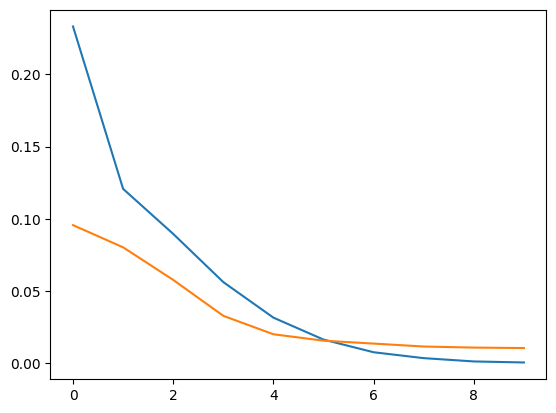

In [276]:
from matplotlib import pyplot as plt 

plt.plot(train_loss)
plt.plot(val_loss)

In [278]:
decoded = decode_strings(X_test[0:10].numpy(), int2char)
model.eval() 
for d,x in zip(decoded, X_test[0:10]): 
    pred, attn = model(x)
    print(f"{d} -> face {'detected' if pred > 0.5 else 'NOT DETECTED'}")

  ✧ツ━_づ━ งP┻ -> face NOT DETECTED
  (▀̿Ĺ̯▀̿ ̿) -> face detected
(✧ω✧)        -> face detected
(o_O)        -> face detected
      (-_-メ) -> face detected
(ʘ‿ʘ)        -> face detected
       (¬‿¬) -> face detected
(・_・;)       -> face detected
       °ω✿̿≧ -> face NOT DETECTED
P(ﾉ▽／☆].*    -> face NOT DETECTED


tensor([1.], grad_fn=<SigmoidBackward0>)